# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [12]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

user_count = 1000.0
desktop_users = int((1/4)*user_count)
mobile_users = int((3/4)*user_count)

for _ in range(desktop_users):
    # Desktop users
    time_on_site = random.uniform(10, 600)
    purchased = random.random() < 0.1 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, False))
  
for _ in range(mobile_users):
    # Mobile users
    time_on_site = random.uniform(5, 300)
    purchased = random.random() < 0.2 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=276.9700934767833, mobile=True), User(purchased=False, time_on_site=187.55340059464294, mobile=True), User(purchased=False, time_on_site=253.33116900288135, mobile=True), User(purchased=True, time_on_site=207.74074485361749, mobile=False), User(purchased=True, time_on_site=241.97740989699577, mobile=True), User(purchased=True, time_on_site=269.59432144097224, mobile=True), User(purchased=True, time_on_site=294.0130503292321, mobile=True), User(purchased=False, time_on_site=108.83814315757766, mobile=True), User(purchased=False, time_on_site=217.32159769597712, mobile=True), User(purchased=False, time_on_site=9.792904563907905, mobile=True)]


In [13]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,276.970093,True
1,False,187.553401,True
2,False,253.331169,True
3,True,207.740745,False
4,True,241.977410,True


In [14]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.523395633613183,5.91922729321219,6.913594757159657,7.241930090793651,7.3854759049726155,8.04867065471391,9.792904563907905,10.189447262863212,11.516382054416482,11.706420835774926,...,573.1550714674758,575.3074663980381,575.910103710396,579.9344161537639,580.5538520236981,583.4316854081177,585.3082868379222,586.5840603032814,595.2360651099401,595.5398050644333
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,1,1
True,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,1,0,0


In [16]:
pd.crosstab(user_data['purchased'], user_data['mobile'])

mobile,False,True
purchased,,
False,166,527
True,84,223


In [31]:
did_not_purchase_count = pd.crosstab(user_data['purchased'], user_data['mobile'])._xs(key=0).sum()
did_purchase_count = pd.crosstab(user_data['purchased'], user_data['mobile'])._xs(key=1).sum()

In [51]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them
time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(0.0822, 2.059]","(2.059, 4.025]","(4.025, 5.992]","(5.992, 7.959]","(7.959, 9.926]"
purchased,,,,,
False,128,240,272,27,26
True,70,102,86,28,21


In [52]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(0.0822, 2.059]","(2.059, 4.025]","(4.025, 5.992]","(5.992, 7.959]","(7.959, 9.926]"
purchased,,,,,
False,0.646465,0.701754,0.759777,0.490909,0.553191
True,0.353535,0.298246,0.240223,0.509091,0.446809


In [53]:
# That seems counter to our hypothesis
# More time on the site can have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.664,0.702667
True,0.336,0.297333


In [54]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,0.170303,-0.036300
time_on_site,0.170303,1.000000,-0.498221
mobile,-0.036300,-0.498221,1.000000


In [55]:
a = time_bins
b = user_data['purchased']
c = user_data['mobile']
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

In [66]:
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

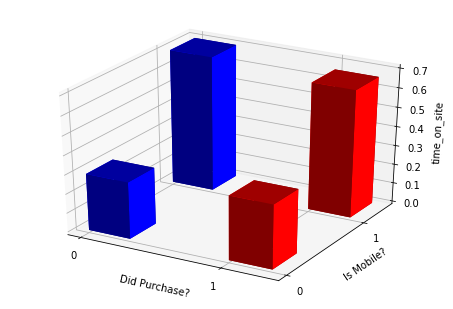

In [111]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2 
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [153]:
tab = pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')
tab

purchased           False               True           
mobile              False     True      False     True 
time_bins                                              
(4.025, 5.992]   0.117318  0.642458  0.025140  0.215084
(2.059, 4.025]   0.102339  0.599415  0.035088  0.263158
(0.0822, 2.059]  0.181818  0.464646  0.070707  0.282828
(7.959, 9.926]   0.553191  0.000000  0.446809  0.000000
(5.992, 7.959]   0.490909  0.000000  0.509091  0.000000

In [154]:
tab.index.categories

IntervalIndex([(0.0822, 2.059], (2.059, 4.025], (4.025, 5.992], (5.992, 7.959], (7.959, 9.926]]
              closed='right',
              dtype='interval[float64]')

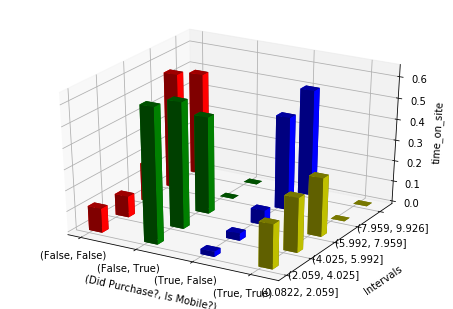

In [181]:
from mpl_toolkits.mplot3d import Axes3D
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

tab = pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')
data = tab.values

column_names = [str(combination) for combination in it.product(*tab.columns.levels)]
row_names = list(map(lambda l: str(l), tab.index.categories))

fig = plt.figure()
ax = Axes3D(fig)

lx= 4
ly= 5
xpos = np.array([0,1,2,3])
ypos = np.array([0,1,2,3,4])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.24 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'g', 'b', 'y'] * ly

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)

ax.xaxis._axinfo['label']['space_factor'] = 2.8

ax.w_xaxis.set_ticklabels(column_names)
ax.w_yaxis.set_ticklabels(row_names, linespacing=5)
ax.axes.set_xticks(np.array([0,1,2,3]))
ax.axes.set_yticks(np.array([0,1,2,3,4]))
ax.set_xlabel('(Did Purchase?, Is Mobile?)', labelpad=10)
ax.set_ylabel('Intervals',  labelpad=20)
ax.set_zlabel('time_on_site')

plt.show()

In [114]:
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.664,0.702667
True,0.336,0.297333


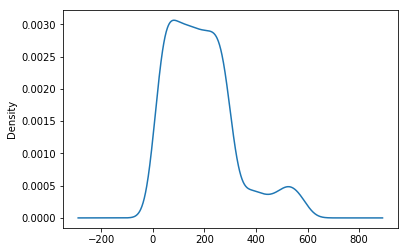

In [71]:
user_data['time_on_site'].plot.density()

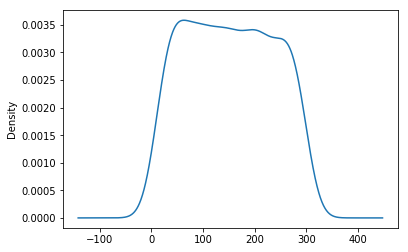

In [73]:
user_data.loc[user_data['mobile'] == True, 'time_on_site'].plot.density()

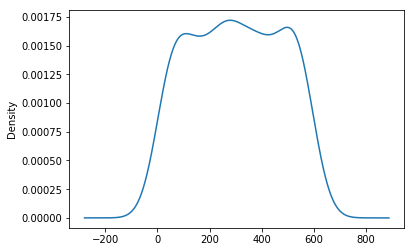

In [74]:
user_data.loc[user_data['mobile'] == False, 'time_on_site'].plot.density()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [72]:
# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd

path = 'persons.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0'])

In [2]:
data.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [3]:
data.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [4]:
data.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


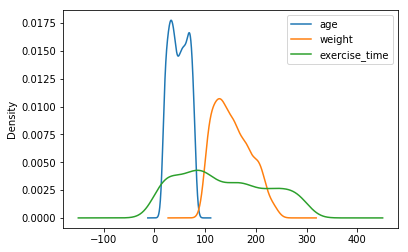

In [6]:
data.plot(kind='density')

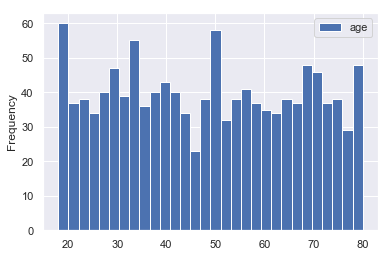

In [160]:
# This plot shows that the frequency difference is not nearly
# as extreme as shown in the density plot

data[['age']].plot.hist(bins=30)

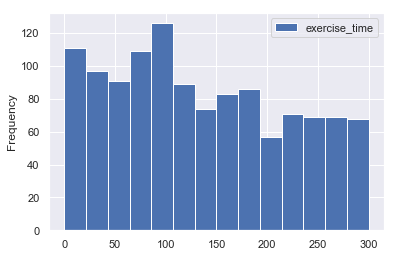

In [157]:
data[['exercise_time']].plot.hist(bins=14)

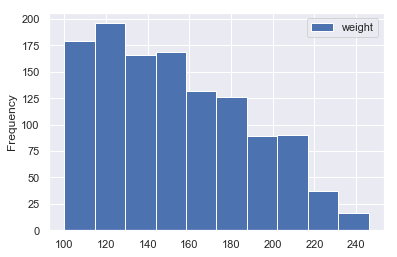

In [151]:
data[['weight']].plot.hist(bins=10)

In [10]:
data[['age']].describe()

,age
count,1200.000000
mean,48.396667
std,18.166802
min,18.000000
25%,33.000000
50%,48.000000
75%,64.000000
max,80.000000


In [184]:
weight_cohorts = pd.cut(data['weight'], 7)
age_cohorts = pd.cut(data['age'], 7)
time_cohorts = pd.cut(data['exercise_time'], 7)
featureful_data = data.assign(weight_cohort=weight_cohorts, age_cohort=age_cohorts, time_cohort=time_cohorts)

featureful_data.head()

,age,weight,exercise_time,weight_cohort,age_cohort,time_cohort
0,44,118,192,"(99.854, 120.857]","(35.714, 44.571]","(171.429, 214.286]"
1,41,161,35,"(141.714, 162.571]","(35.714, 44.571]","(-0.3, 42.857]"
2,46,128,220,"(120.857, 141.714]","(44.571, 53.429]","(214.286, 257.143]"
3,39,216,57,"(204.286, 225.143]","(35.714, 44.571]","(42.857, 85.714]"
4,28,116,182,"(99.854, 120.857]","(26.857, 35.714]","(171.429, 214.286]"


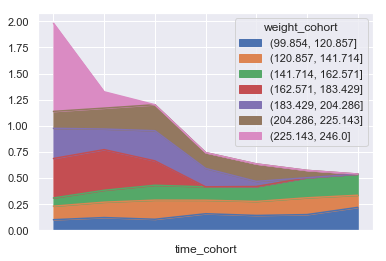

In [185]:
import matplotlib.pyplot as plt

exercise_time = featureful_data['exercise_time']
features = featureful_data.drop(columns=['exercise_time'])
feature_count = len(list(features))

pd.crosstab(features['time_cohort'], features['weight_cohort'], normalize='columns').plot.area()

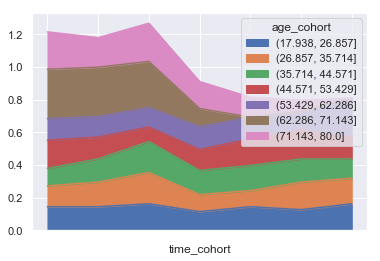

In [186]:
pd.crosstab(features['time_cohort'], features['age_cohort'], normalize='columns').plot.area()

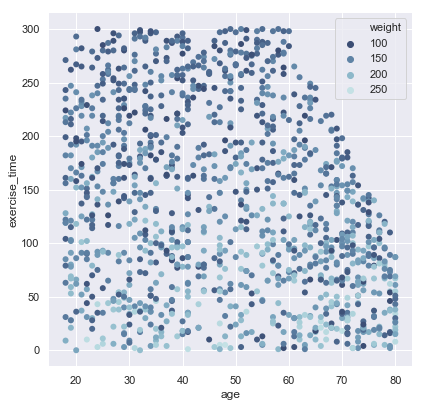

In [229]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(
    x="age", 
    y="exercise_time",
    hue="weight", 
    palette="ch:r=-.2,d=.3_r",
    sizes=(1, 8), 
    linewidth=0,
    data=data, 
    ax=ax
)

In [188]:
time_by_age = pd.crosstab(features['time_cohort'], features['age_cohort'], normalize='columns')
time_by_age

age_cohort,"(17.938, 26.857]","(26.857, 35.714]","(35.714, 44.571]","(44.571, 53.429]","(53.429, 62.286]","(62.286, 71.143]","(71.143, 80.0]"
time_cohort,,,,,,,
"(171.429, 214.286]",0.144578,0.127907,0.106509,0.173267,0.132450,0.302632,0.228723
"(-0.3, 42.857]",0.144578,0.151163,0.142012,0.133663,0.125828,0.302632,0.180851
"(214.286, 257.143]",0.162651,0.191860,0.189349,0.089109,0.119205,0.282895,0.234043
"(42.857, 85.714]",0.114458,0.104651,0.147929,0.128713,0.139073,0.111842,0.164894
"(128.571, 171.429]",0.144578,0.098837,0.153846,0.163366,0.132450,0.000000,0.122340
"(85.714, 128.571]",0.126506,0.168605,0.142012,0.178218,0.112583,0.000000,0.069149
"(257.143, 300.0]",0.162651,0.156977,0.118343,0.133663,0.238411,0.000000,0.000000


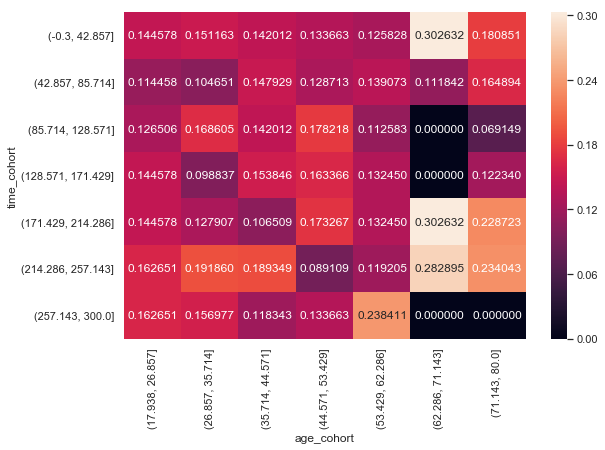

In [541]:
import seaborn as sns
sns.set()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(time_by_age.sort_values(by='time_cohort'), annot=True, fmt="f")

In [539]:
time_by_weight = pd.crosstab(features['time_cohort'], features['weight_cohort'], normalize='columns').sort_values(by='time_cohort')
time_by_weight

weight_cohort,"(99.854, 120.857]","(120.857, 141.714]","(141.714, 162.571]","(162.571, 183.429]","(183.429, 204.286]","(204.286, 225.143]","(225.143, 246.0]"
time_cohort,,,,,,,
"(-0.3, 42.857]",0.121951,0.147321,0.113879,0.388889,0.197183,0.200000,0.15625
"(42.857, 85.714]",0.158537,0.129464,0.128114,0.000000,0.176056,0.151351,0.00000
"(85.714, 128.571]",0.150407,0.160714,0.192171,0.000000,0.000000,0.070270,0.00000
"(128.571, 171.429]",0.142276,0.133929,0.142349,0.000000,0.049296,0.167568,0.00000
"(171.429, 214.286]",0.101626,0.129464,0.078292,0.377778,0.288732,0.162162,0.84375
"(214.286, 257.143]",0.105691,0.183036,0.142349,0.233333,0.288732,0.248649,0.00000
"(257.143, 300.0]",0.219512,0.116071,0.202847,0.000000,0.000000,0.000000,0.00000


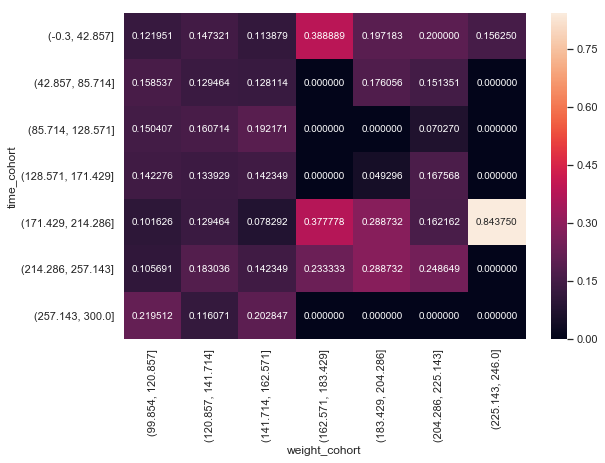

In [540]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(time_by_weight, annot=True, fmt="f")

In [557]:
data.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


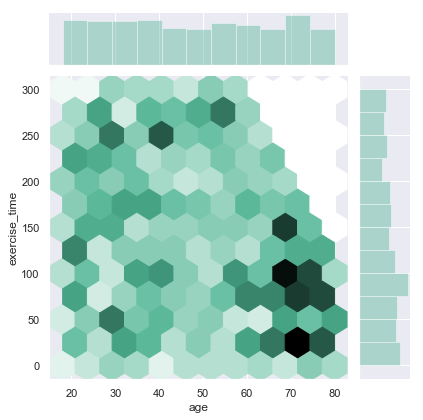

In [191]:
sns.jointplot(data['age'], data['exercise_time'], kind="hex", color="#4CB391")

In [193]:
featureful_data.head()

,age,weight,exercise_time,weight_cohort,age_cohort,time_cohort
0,44,118,192,"(99.854, 120.857]","(35.714, 44.571]","(171.429, 214.286]"
1,41,161,35,"(141.714, 162.571]","(35.714, 44.571]","(-0.3, 42.857]"
2,46,128,220,"(120.857, 141.714]","(44.571, 53.429]","(214.286, 257.143]"
3,39,216,57,"(204.286, 225.143]","(35.714, 44.571]","(42.857, 85.714]"
4,28,116,182,"(99.854, 120.857]","(26.857, 35.714]","(171.429, 214.286]"


In [237]:
melted_data = pd.melt(data, "weight", var_name="properties")
melted_data.head()

,weight,properties,value
0,118,age,44
1,161,age,41
2,128,age,46
3,216,age,39
4,116,age,28


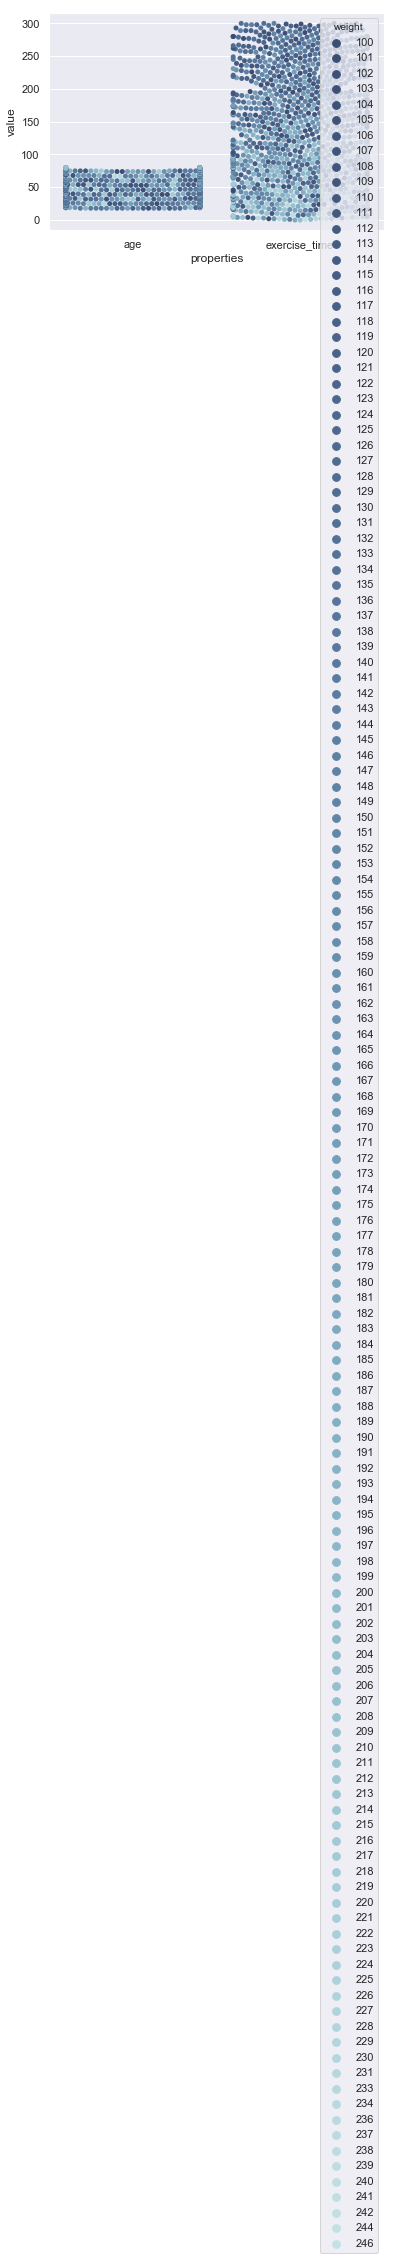

In [240]:
sns.swarmplot(
    x="properties", 
    y="value",
    hue="weight", 
    palette="ch:r=-.2,d=.3_r",
    data=melted_data
)

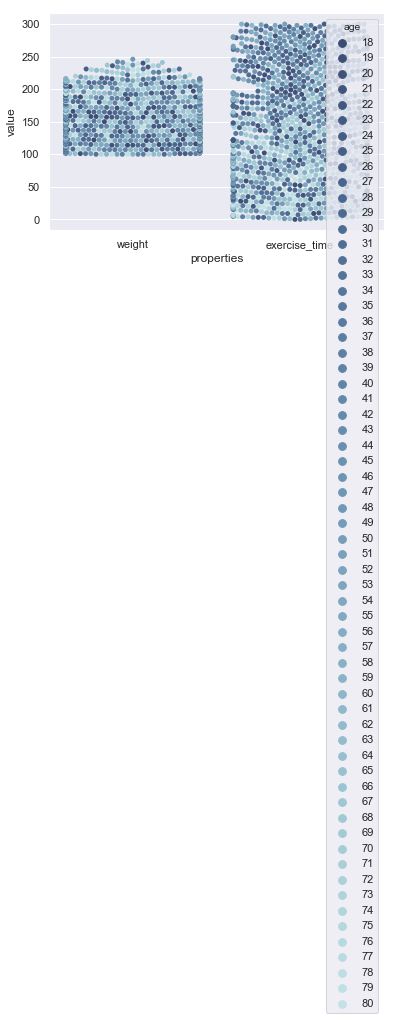

In [235]:
melted_data = pd.melt(data, "age", var_name="properties")

sns.swarmplot(
    x="properties", 
    y="value",
    hue="age", 
    palette="ch:r=-.2,d=.3_r",
    data=melted_data
)

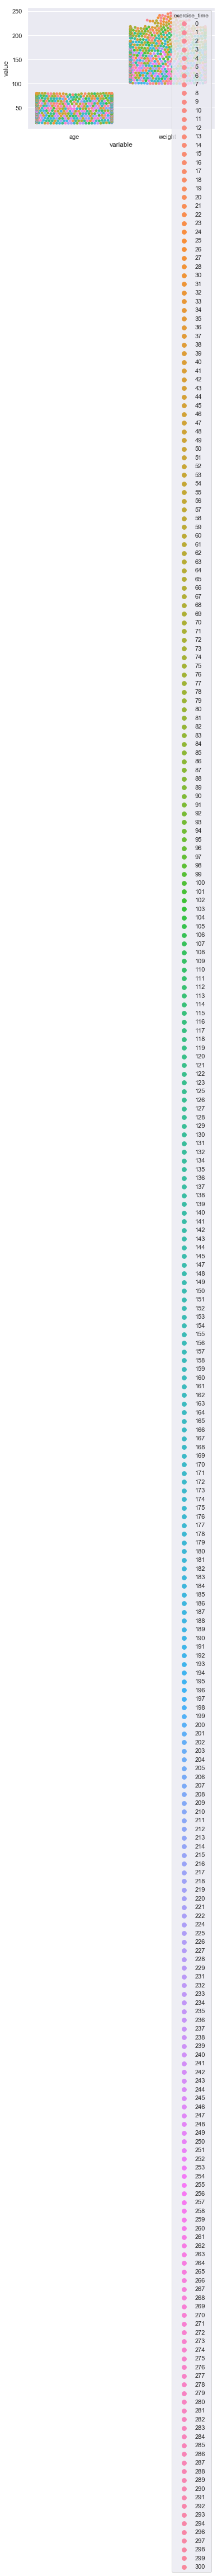

In [241]:
melted_data = pd.melt(data, "exercise_time")

sns.swarmplot(
    x="variable",
    y="value",
    hue="exercise_time",
    data=melted_data
)

In [327]:
def pandas_bin(df, series, n):    
    intervals = pd.cut(series, n).unique().categories.values
    match_mat = [[x in i for x in df[series.name]] for i in intervals]
    return [df[matches] for matches in match_mat]
    
inactive, normal, active = pandas_bin(data, data['exercise_time'], 3)

inactive.shape, normal.shape, active.shape

((505, 3), (384, 3), (311, 3))

Text(40,80,'active')

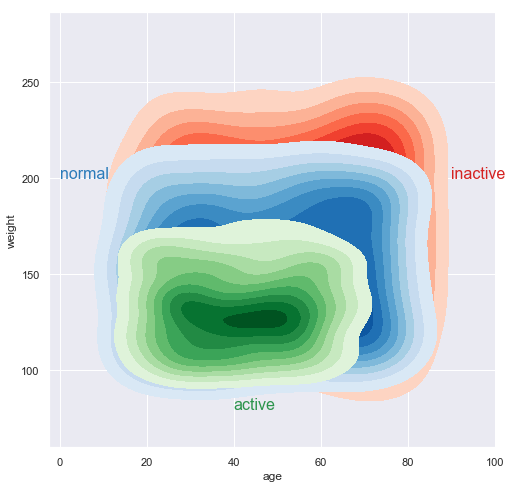

In [328]:
# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots
ax = sns.kdeplot(inactive['age'], inactive['weight'], cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(normal['age'], normal['weight'], cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(active['age'], active['weight'], cmap="Greens", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0, 200, "normal", size=16, color=blue)
ax.text(90, 200, "inactive", size=16, color=red)
ax.text(40, 80, "active", size=16, color=green)

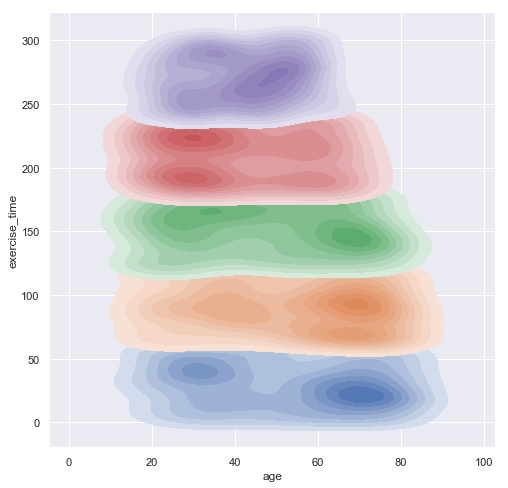

In [552]:
def pandas_bin(df, series, n):    
    intervals = pd.cut(series, n).unique().categories.values
    match_mat = [[x in i for x in df[series.name]] for i in intervals]
    return [df[matches] for matches in match_mat]
    
f, ax = plt.subplots(figsize=(8, 8))
    
for age_group in pandas_bin(data, data['exercise_time'], 5):
    ax = sns.kdeplot(age_group['age'], age_group['exercise_time'], shade=True, shade_lowest=False)

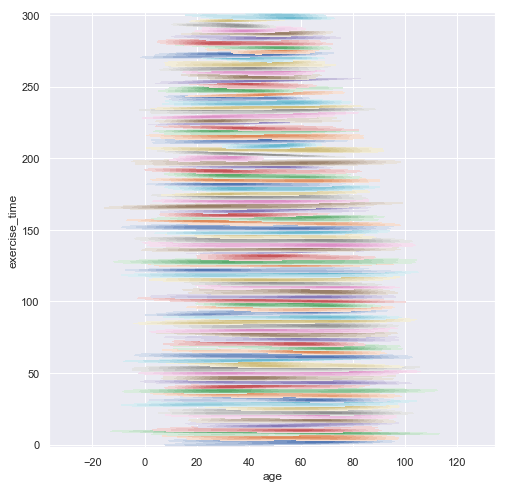

In [554]:
def pandas_bin(df, series, n):    
    intervals = pd.cut(series, n).unique().categories.values
    match_mat = [[x in i for x in df[series.name]] for i in intervals]
    return [df[matches] for matches in match_mat]
    
f, ax = plt.subplots(figsize=(8, 8))
    
for age_group in pandas_bin(data, data['exercise_time'], 100):
    ax = sns.kdeplot(age_group['age'], age_group['exercise_time'], shade=True, shade_lowest=False)

In [458]:
# Just as an aside, I was wondering over what interval correlations stabalize so I 
# plotted rolling averages of correlations over different window sizes, and plotted them.

import itertools as it

n = 1
m = 40
step = 1

df = {
    'age': [], 
    'weight': [], 
    'exercise_time': [], 
    'window_size': []
}

for i in range(n,m,step):
    df['window_size'].append(i)
    for label in data:
        df[label].append(data.rolling(i).corr().dropna().mean()[label])
        
correlations_over_windows = pd.DataFrame(df)

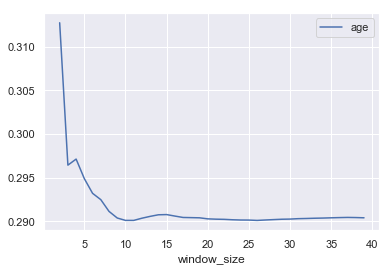

In [461]:
correlations_over_windows[1:].plot.line(x='window_size', y='age')

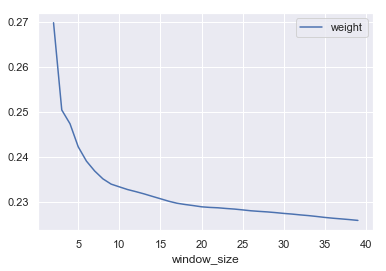

In [462]:
correlations_over_windows[1:].plot.line(x='window_size', y='weight')

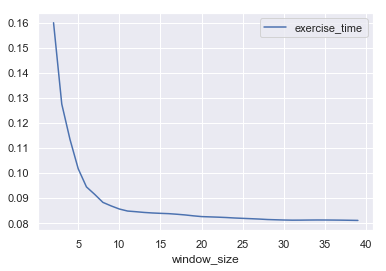

In [463]:
correlations_over_windows[1:].plot.line(x='window_size', y='exercise_time')

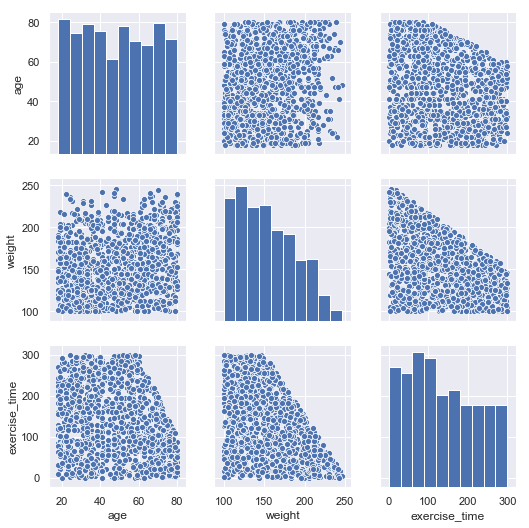

In [329]:
sns.pairplot(data);

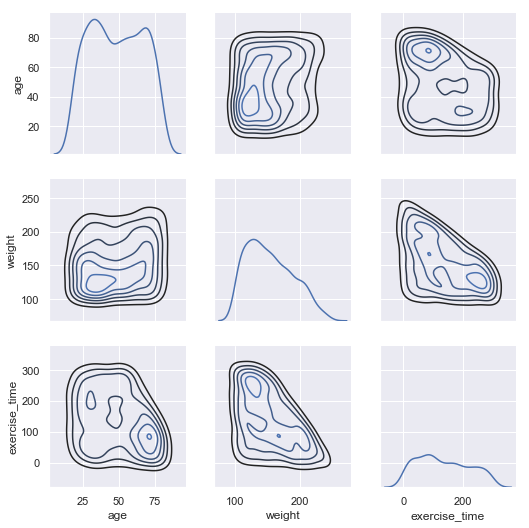

In [330]:
g = sns.PairGrid(data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The `weight` and `features` columns are continuous, whereas the `age` column is discrete.

2.  What are the relationships between the variables?

Of the relationships we have available to us:
 - `exercise_time` and `weight`: Negatively correlated, however the latter as a function of the former
 could be confounding in that younger individuals are predispoed to weight less regardless of how much
 they exercise.
 - `age` and `weight`: Hardly correlated at all, which is what you would expect, as our data isn't split
 up into the many variables wherein some correlation might lie. For example, sex alone would probably
 reveal individual correlations in opposite directions. 
 - `exercise_time` and `age`: Positively correlated, albeit quite weak. This seems roughly consistent with
 what should be expected, infants don't exercise and neither do the very old. However it's not exactly clear
 that this is a feature of the distribution the data is drawn from as opposed to the structure of the data
 we have at hand. If you look to the hexplot and heatmap above which plots these two features against eachother
 you can see that we have much more entries from old people than we do from other cohorts.
 
3.  Which relationships are "real", and which spurious?

As discussed above the relationship between `exercise_time` and `age` is likely to be somewhat spurious. The relationship between `exercise_time` and `weight` seems most likely to be real though if you look at the composition of the data at hand you can see from the heatmap above that over 80% of the data is composed of people who are above average both in there weight _and_ in the amount of time they spent exercising, this seems odd to me, though the scatter plots clearly show a relation of some kind. `age` and `weight` seems to be completely uncorrelated and thus real? Under the definition that 'read'-ness is data that reflects the underlying distribution.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)